In [27]:
import os
from typing import Tuple

from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

# from django.conf import settings


Dataset file loader

In [28]:
class DataFileAndLoader(object):
    def __init__(self):
        self.data_file_path = None

    def dataset_file_path(self):
        try:
            if self.data_file_path is None:
                self.data_file_path = os.path.join('/kaggle/input/loan-prediction-dataset', 'train.csv')
                print(f"Data file path: {self.data_file_path}")
            return self.data_file_path
        except FileNotFoundError as e:
            print(f"Error: {e}")

    def load_dataset_file(self):
        load_dataset_file = pd.read_csv(self.dataset_file_path())
        print(f"Loaded dataset: {load_dataset_file}")
        return load_dataset_file


Dataset processing, cleaning, filling the missing values and encoding the data
Scaling the data

In [29]:
class DataProcessing(object):
    def __init__(self, load_dataset_file):
        self.load_dataset = load_dataset_file
        self.gender_loan_status = None

        # Remove the 'Loan_ID' column
        self.load_dataset.drop('Loan_ID', axis=1, inplace=True)

    def data_filling_empty(self):

        # Filling up the missing values in the columns and rows affected
        self.load_dataset['Gender'] = self.load_dataset['Gender'].fillna(self.load_dataset['Gender'].mode()[0])
        self.load_dataset['Married'] = self.load_dataset['Married'].fillna(self.load_dataset['Married'].mode()[0])
        self.load_dataset['Dependents'] = self.load_dataset['Dependents'].str.replace(r"\+", "", regex=True)
        self.load_dataset['Dependents'] = pd.to_numeric(self.load_dataset['Dependents'])
        self.load_dataset['Dependents'] = self.load_dataset['Dependents'].fillna(self.load_dataset['Dependents'].mode()[0])
        self.load_dataset['Self_Employed'] = self.load_dataset['Self_Employed'].fillna(self.load_dataset['Self_Employed'].mode()[0])
        self.load_dataset['LoanAmount'] = self.load_dataset['LoanAmount'].fillna(self.load_dataset['LoanAmount'].mean())
        self.load_dataset['Loan_Amount_Term'] = self.load_dataset['Loan_Amount_Term'].fillna(self.load_dataset['Loan_Amount_Term'].mean())
        self.load_dataset['Credit_History'] = self.load_dataset['Credit_History'].fillna(self.load_dataset['Credit_History'].mean())
        
        # store gender and loan status information
        self.gender_loan_status = self.load_dataset[['Gender', 'Loan_Status']]
        
        return self.load_dataset

    def data_encoding(self):
        # label encoding
        self.load_dataset['Gender'] = self.load_dataset['Gender'].map({'Male': 0, 'Female': 1}).astype(int)
        self.load_dataset['Married'] = self.load_dataset['Married'].map({'No': 0, 'Yes': 1}).astype(int)
        self.load_dataset['Dependents'] = self.load_dataset['Dependents'].astype(int)
        self.load_dataset['Education'] = self.load_dataset['Education'].map({'Not Graduate': 0, 'Graduate': 1}).astype(int)
        self.load_dataset['Self_Employed'] = self.load_dataset['Self_Employed'].map({'No': 0, 'Yes': 1}).astype(int)
        self.load_dataset['ApplicantIncome'] = self.load_dataset['ApplicantIncome'].astype(int)
        self.load_dataset['CoApplicantIncome'] = self.load_dataset['CoApplicantIncome'].astype(int)
        self.load_dataset['Credit_History'] = self.load_dataset['Credit_History'].astype(int)
        self.load_dataset['Property_Area'] = self.load_dataset['Property_Area'].map({'Urban': 0, 'Rural': 1, 'SemiUrban': 2}).astype(int)
        self.load_dataset['Loan_Status'] = self.load_dataset['Loan_Status'].map({'N': 0, 'Y': 1}).astype(int)
        return self.load_dataset

    def scaling_the_data(self):
        # scale the data
        scaler = StandardScaler()
        # split into features and target
        X = self.load_dataset.drop('Loan_Status', axis=1)
        X = scaler.fit_transform(X)
        Y = self.load_dataset['Loan_Status']
        # handling class imbalance using SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, Y)
        return X_resampled, y_resampled, scaler


Model trainer class

In [33]:
class ModelTrainer(object):
    """
    This class is used to train the model and evaluate the model performance.
    It also provides the hyperparameter tuning for individual models
    It is initialized with the resampled data
    """
    def __init__(self, x_resampled, y_resampled):
        self.x_resampled = x_resampled
        self.y_resampled = y_resampled

    def train_split(self, test_size=0.2, random_state=4):
        """
        This function is used to split the data into train and test
        :param test_size:
        :param random_state:
        :return train_x, train_y, test_x, test_y
        """
        # # split into train and test
        x_train, x_test, y_train, y_test = train_test_split(self.x_resampled, self.y_resampled, test_size=test_size, random_state=random_state)

        # model training and evaluation for individual models
        rf_params = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        ada_params = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1.0]
        }
        grd_params = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 1.0],
            'max_depth': [3, 5, 7]
        }
        log_params = {
            'C': [0.1, 1, 10]
        }
        svm_params = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
        return rf_params, ada_params, grd_params, log_params, svm_params, x_train, x_test, y_train, y_test

    def classifiers_train_models(self, rf_params, ada_params, grd_params, log_params, svm_params, x_train, x_test, y_train, y_test):
        # Create a dictionary of classifiers and their respective parameter grids
        rand_classifiers = {
            'RandomForestClassifier': (RandomForestClassifier(), rf_params),
            'AdaBoostClassifier': (AdaBoostClassifier(), ada_params),
            'GradientBoostingClassifier': (GradientBoostingClassifier(), grd_params),
            'LogisticRegression': (LogisticRegression(), log_params),
            'SVC': (SVC(), svm_params)
        }
        # Train and evaluate each classifier
        rand_best_classifiers = {}
        # Loop through each classifier and perform RandomizedSearchCV
        for name, (classifier, params) in rand_classifiers.items():
            random_search = RandomizedSearchCV(classifier, param_distributions=params, n_iter=10, cv=5, n_jobs=-1, random_state=42)
            random_search.fit(x_train, y_train)
            rand_best_classifiers[name] = random_search.best_estimator_
            print(f"{name} best parameters: {random_search.best_params_}")
            print(f"{name} best score: {random_search.best_score_}")
        return rand_best_classifiers, x_test, y_test,  x_train, y_train

    def evaluate_models(self, rand_best_classifiers, x_test, y_test, x_train, y_train):
        # Evaluate the performance of each classifier
        for name, classifier in rand_best_classifiers.items():
            classifier.fit(x_train, y_train).predict(x_test)
            y_pred = classifier.predict(x_test)
            print(f"{name} accuracy: {accuracy_score(y_test, y_pred)}")
            print(f"{name} precision: {precision_score(y_test, y_pred)}")
            print(f"{name} recall: {recall_score(y_test, y_pred)}")
            print(f"{name} f1 score: {f1_score(y_test, y_pred)}")

    def get_classifier(self, rand_best_classifiers, x_test, y_test, x_train, y_train):
        random_forest_classifier = rand_best_classifiers['RandomForestClassifier']
        adaboost_classifier = rand_best_classifiers['AdaBoostClassifier']
        gradient_boosting_classifier = rand_best_classifiers['GradientBoostingClassifier']
        logistic_regression = rand_best_classifiers['LogisticRegression']
        naive_bayes_classifier = GaussianNB()
        svm_classifier = rand_best_classifiers['SVC']

        # Cross-validation
        classifiers = {'Random Forest': random_forest_classifier, 'Adaboost': adaboost_classifier,
                       'Gradient Boosting': gradient_boosting_classifier, 'Logistic Regression': logistic_regression,
                       'Naive Bayes': naive_bayes_classifier, 'SVM': svm_classifier}
        accuracy_scores = {}
        improved_classifiers = {}
        best_accuracy = 0
        for name, classifier in classifiers.items():
            scores = cross_val_score(classifier, x_train, y_train, cv=10, scoring='accuracy')
            mean_score = scores.mean()
            accuracy_scores[name] = mean_score
            if mean_score > best_accuracy:
                best_accuracy = mean_score
                improved_classifiers = {name: classifier}
            elif mean_score == best_accuracy:
                improved_classifiers[name] = classifier
        # Print the accuracies and improved classifiers
        print("Classifier Accuracies:", accuracy_scores)
        
        for name, accuracy in accuracy_scores.items():
            print(f"{name} accuracy: {accuracy}")
        return improved_classifiers, x_test, y_test,  x_train, y_train


Ensemble model class

In [36]:
class EnsembleModel(object):
    """
    Initialize the EnsembleModel class with the improved classifiers, test data, and training data
    Parameters:
        improved_classifiers (dict): A dictionary of the improved classifiers
        x_test (numpy.ndarray): The test data
        y_test (numpy.ndarray): The test labels
        x_train (numpy.ndarray): The training data
        y_train (numpy.ndarray): The training labels
    """
    def __init__(self, improved_classifiers, x_test, y_test, x_train, y_train):
        self.improved_classifiers = improved_classifiers
        self.x_test = x_test
        self.y_test = y_test
        self.x_train = x_train
        self.y_train = y_train

    def get_ensemble_model(self):
        """
        Get the ensemble model from the improved classifiers
        :return:
        ensemble_accuracy:
        f1_ensemble_accuracy:
        precision_score_accuracy:
        meta_predictions:
        """

        meta_ensemble = VotingClassifier(estimators=[
            (name, classifier) for name, classifier in self.improved_classifiers.items()], voting='hard')
        meta_ensemble.fit(self.x_train, self.y_train)
        meta_predictions = meta_ensemble.predict(self.x_test)
        
        result_df = pd.DataFrame({'Actual': self.y_test, 'Predicted': meta_predictions})

        ensemble_accuracy = accuracy_score(self.y_test, meta_predictions)
        f1_ensemble_accuracy = f1_score(self.y_test, meta_predictions)
        precision_score_accuracy = precision_score(self.y_test, meta_predictions)
        recall_score_accuracy = recall_score(self.y_test, meta_predictions)

        return ensemble_accuracy, f1_ensemble_accuracy, precision_score_accuracy, recall_score_accuracy, meta_ensemble, result_df


Model Storing into a pickle file

In [37]:
class ModelStore(object):
    """
    Initialize ModelStore with meta_ensemble_model and scaler_model.

    Args:
        meta_ensemble_model: The meta ensemble model.
        scaler_model: The scaler model.
    """
    def __init__(self, meta_ensemble_model, scaler_model):
        self.meta_predictions = meta_ensemble_model
        self.scaler = scaler_model

    def store_model(self):
        """
        Prompt the user for model and scaler filenames and store the models to files.
        """
        model_filename, scaler_filename = self.name_file()

        scaler_file_dir = os.path.join(settings.PICKLES_DIR_PATH, scaler_filename)
        model_file_dir = os.path.join(settings.PICKLES_DIR_PATH, model_filename)

        joblib.dump(self.scaler, scaler_file_dir)
        print(f"Scaler was successfully saved to {scaler_file_dir}")
        joblib.dump(self.meta_predictions, model_file_dir)
        print(f"Model was successfully saved to {model_file_dir}")

    def name_file(self) -> Tuple[str, str]:
        """
        Prompt the user for model and scaler filenames.

        Returns:
            Tuple[str, str]: A tuple containing the model and scaler filenames.
        """
        default_model_name = "model.pkl"
        default_scaler_name = "scaler.pkl"

        model_name = default_model_name
        scaler_name = default_scaler_name
        return model_name, scaler_name


Main project run

Data file path: /kaggle/input/loan-prediction-dataset/train.csv
Loaded dataset:       Loan_ID  Gender Married Dependents     Education Self_Employed  \
0    LP001002    Male      No          0      Graduate            No   
1    LP001003    Male     Yes          1      Graduate            No   
2    LP001005    Male     Yes          0      Graduate           Yes   
3    LP001006    Male     Yes          0  Not Graduate            No   
4    LP001008    Male      No          0      Graduate            No   
..        ...     ...     ...        ...           ...           ...   
609  LP002978  Female      No          0      Graduate            No   
610  LP002979    Male     Yes         3+      Graduate            No   
611  LP002983    Male     Yes          1      Graduate            No   
612  LP002984    Male     Yes          2      Graduate            No   
613  LP002990  Female      No          0      Graduate           Yes   

     ApplicantIncome  CoApplicantIncome  LoanAmount  Lo

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AdaBoostClassifier best parameters: {'n_estimators': 50, 'learning_rate': 1.0}
AdaBoostClassifier best score: 0.7422222222222221
GradientBoostingClassifier best parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 1.0}
GradientBoostingClassifier best score: 0.7614814814814814
LogisticRegression best parameters: {'C': 1}
LogisticRegression best score: 0.6992592592592592


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SVC best parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
SVC best score: 0.7422222222222221
Classifier Accuracies: {'Random Forest': 0.7954345917471466, 'Adaboost': 0.7362379280070237, 'Gradient Boosting': 0.7480026338893767, 'Logistic Regression': 0.6918129938542581, 'Naive Bayes': 0.6813432835820896, 'SVM': 0.7449956101843722}
Random Forest accuracy: 0.7954345917471466
Adaboost accuracy: 0.7362379280070237
Gradient Boosting accuracy: 0.7480026338893767
Logistic Regression accuracy: 0.6918129938542581
Naive Bayes accuracy: 0.6813432835820896
SVM accuracy: 0.7449956101843722


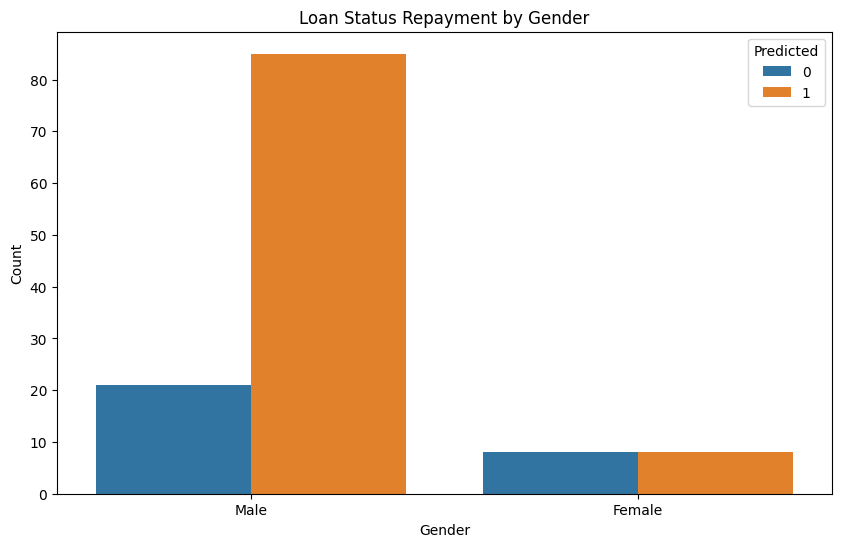

Ensemble accuracy: 0.7810650887573964
Ensemble f1 score: 0.8042328042328042
Ensemble precision score: 0.7238095238095238
Ensemble recall score: 0.9047619047619048


In [38]:
# if __name__ == '__main__':
data_loader = DataFileAndLoader()
load_dataset = data_loader.load_dataset_file()

data_processor = DataProcessing(load_dataset)
data_processor.data_filling_empty()
data_processor.data_encoding()

x_sampled, y_sampled, scaler = data_processor.scaling_the_data()

model_trainer = ModelTrainer(x_sampled, y_sampled)
rf_params, ada_params, grd_params, log_params, svm_params, x_train, x_test, y_train, y_test = model_trainer.train_split()
model_classifiers, x_test, y_test, x_train, y_train = model_trainer.classifiers_train_models(rf_params, ada_params, grd_params, log_params, svm_params, x_train, x_test, y_train, y_test)
improved_classifier, x_test, y_test, x_train, y_train = model_trainer.get_classifier(model_classifiers, x_test, y_test, x_train, y_train)

ensemble_model = EnsembleModel(improved_classifier, x_test, y_test, x_train, y_train)
ensemble_model_accuracy, f1_ensemble_model_accuracy, precision_score_model_accuracy, recall_score_model_accuracy, meta_model_ensemble, result_dataframe = ensemble_model.get_ensemble_model()

result_dataframe_merge = pd.merge(result_dataframe, data_processor.gender_loan_status, left_index=True, right_index=True)
# Create a bar chart to visualize the rate of loan status repayment for females and males
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Predicted', data=result_dataframe_merge)
plt.title('Loan Status Repayment by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

print(f"Ensemble accuracy: {ensemble_model_accuracy}")
print(f"Ensemble f1 score: {f1_ensemble_model_accuracy}")
print(f"Ensemble precision score: {precision_score_model_accuracy}")
print(f"Ensemble recall score: {recall_score_model_accuracy}")

# save the model
# model_store = ModelStore(meta_model_ensemble, scaler)
# model_store.store_model()


In [44]:
new_data = pd.DataFrame({
    'Gender': ['Male'],
    'Married': ['Yes'],
    'Dependents': [1],
    'Education': ['Graduate'],
    'Self_Employed': ['Yes'],
    'ApplicantIncome': [1000],
    'CoApplicantIncome': [100],
    'LoanAmount': [3000],
    'Loan_Amount_Term': [360],
    'Credit_History': [1],
    'Property_Area': ['Urban']
})

# label encoding
new_data['Gender'] = new_data['Gender'].map({'Male': 0, 'Female': 1}).astype(int)
new_data['Married'] = new_data['Married'].map({'No': 0, 'Yes': 1}).astype(int)
new_data['Dependents'] = new_data['Dependents'].astype(int)
new_data['Education'] = new_data['Education'].map({'Not Graduate': 0, 'Graduate': 1}).astype(int)
new_data['Self_Employed'] = new_data['Self_Employed'].map({'No': 0, 'Yes': 1}).astype(int)
new_data['ApplicantIncome'] = new_data['ApplicantIncome'].astype(int)
new_data['CoApplicantIncome'] = new_data['CoApplicantIncome'].astype(int)
new_data['LoanAmount'] = new_data['LoanAmount'].astype(int)
new_data['Loan_Amount_Term'] = new_data['Loan_Amount_Term'].astype(int)
new_data['Credit_History'] = new_data['Credit_History'].astype(int)
new_data['Property_Area'] = new_data['Property_Area'].map({'Urban': 0, 'Rural': 1, 'SemiUrban': 2}).astype(int)

# Use the scaler to scale the new data
new_data_scaled = scaler.transform(new_data)


# Use the ensemble model to make predictions
new_predictions = meta_model_ensemble.predict(new_data_scaled)

# Print the predictions
print("Predictions for new data:")
print(new_predictions)

Predictions for new data:
[1]
